1. Industry performance across regimes
1. Industry average weight across regimes (need results for this)
1. Regimes probabilities across time
1. Performance of the three factors across regimes

In [1]:
import pandas as pd
from regimeaware.routines import cfg
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
from regimeaware.routines import cfg
import numpy as np
from sklearn import preprocessing
from hmmlearn.hmm import GaussianHMM
from matplotlib.ticker import StrMethodFormatter

dpi = 300
width = 7.5
height = 4.5

emission_prob = pd.read_pickle(f"{cfg.data_fldr}/regimes/emission_prob.pkl")
transition_matrix = pd.read_pickle(f"{cfg.data_fldr}/regimes/transmat.pkl")
ff_raw = pd.read_pickle(f'{cfg.data_fldr}/ff_daily.pkl').sort_index()[cfg.factor_set + ['umd']]
weekly_dts = pd.date_range(start=ff_raw.index[0], end=ff_raw.index[-1], freq=cfg.data_freq)
ff = ff_raw.loc[weekly_dts[0]:weekly_dts[-1]].add(1).groupby(pd.Grouper(freq=cfg.data_freq)).prod().sub(1)

# Load cached factor estimates
factor_covars = pd.read_pickle(f'{cfg.data_fldr}/moments/factor_covars.pkl')
factor_means = pd.read_pickle(f'{cfg.data_fldr}/moments/factor_means.pkl')
factor_loadings = pd.read_pickle(f'{cfg.data_fldr}/exposures/forecasted_betas.pkl')
factor_variance = pd.read_pickle(f'{cfg.data_fldr}/exposures/var.pkl')

# Reference market cap weights
crsp = pd.read_pickle(f'{cfg.data_fldr}/crsp.pkl')
mktcap = crsp['mktcap'].copy()

In [5]:
pd.read_pickle(f'{cfg.data_fldr}/crsp_daily.pkl')

date        permno
1960-01-04  10006     0.038660
            10014     0.055556
            10022    -0.018182
            10030     0.000000
            10057     0.011547
                        ...   
2022-12-30  93423     0.007366
            93426    -0.016539
            93429    -0.013446
            93434    -0.019737
            93436     0.011164
Name: ret, Length: 72791458, dtype: float64

In [2]:
factor_loadings.groupby(['date', 'id']).sum().groupby('date').count()

date
2002-12-31    4089
2003-01-31    4082
2003-02-28    4090
2003-03-31    4082
2003-04-30    4079
              ... 
2022-08-31    2822
2022-09-30    2828
2022-10-31    2835
2022-11-30    2845
2022-12-31    2842
Length: 241, dtype: int64

In [3]:
factor_loadings

date        id     factor
2002-12-31  81920  const    -0.001195
                   mktrf     1.128476
                   smb       1.029034
                   hml      -0.474559
                   rmw      -1.960184
                               ...   
2022-12-31  16382  mktrf     1.369381
                   smb      -0.706582
                   hml      -0.693790
                   rmw      -1.960408
                   cma      -0.032957
Length: 4749276, dtype: float64

count    241.000000
mean       0.928040
std        0.011108
min        0.904671
25%        0.919553
50%        0.926358
75%        0.936376
max        0.951356
Name: mktcap, dtype: float64

count     241.000000
mean     3284.423237
std       461.163279
min      2745.000000
25%      2828.000000
50%      3242.000000
75%      3605.000000
max      4108.000000
dtype: float64

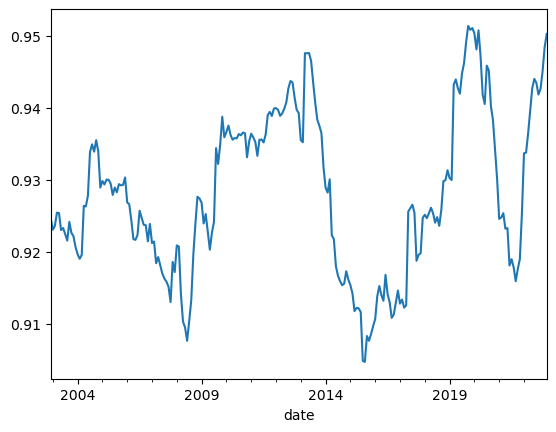

In [27]:
investable_flag = factor_loadings.groupby(['date', 'id']).sum().astype(bool)
investable_mc = mktcap.reindex(investable_flag.index).groupby(['date']).sum()
total_mc = mktcap.groupby('date').sum()
investable_mc_pct = investable_mc.div(total_mc).dropna()
investable_mc_pct.plot()
display(investable_mc_pct.describe())

display(investable_flag.groupby('date').count().describe())

<Axes: xlabel='date'>

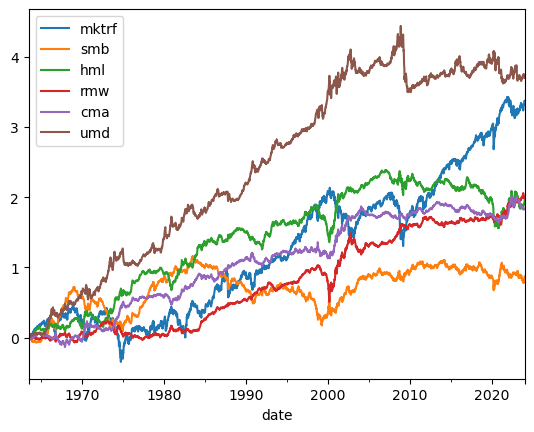

In [66]:
ff.add(1).cumprod().apply(np.log).plot()

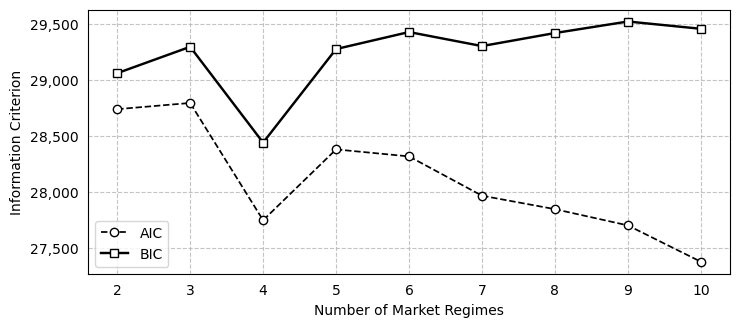

In [35]:
states_to_try = range(2, 11)

bic = pd.Series(index=states_to_try, dtype=float)
aic = pd.Series(index=states_to_try, dtype=float)
trn_raw = ff.loc[cfg.trn_start_dt:cfg.bt_start_dt]
scaler = preprocessing.StandardScaler(copy=True).fit(trn_raw)
trn_std = scaler.transform(trn_raw)

for n in states_to_try:    
    mdl = GaussianHMM(
        n_components=n,
        covariance_type="full",
        random_state=0,
    )
    mdl.fit(trn_std)
    bic[n] = mdl.bic(trn_std)
    aic[n] = mdl.aic(trn_std)

# Plotting
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(width, height * .75), sharex=True, sharey=False)
plot_map = {'AIC': (aic, '--', 1.25, 'o'), 'BIC': (bic, '-', 1.75, 's')}

for label, params in plot_map.items():
    ax.plot(params[0], color='k', marker=params[3], mfc='white', lw=params[2], ls=params[1])
    ax.grid(ls='--', alpha=.75)

# ax.set_title('Information Criterion', weight='bold')
ax.set_ylabel('Information Criterion')
ax.set_xlabel('Number of Market Regimes')
ax.legend(['AIC', 'BIC'])
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.tick_params(axis='both', bottom=False, left=False)
plt.tight_layout()
plt.savefig(f"{cfg.fldr}/img/state_calibration.pdf", dpi=dpi, transparent=True)
plt.show()


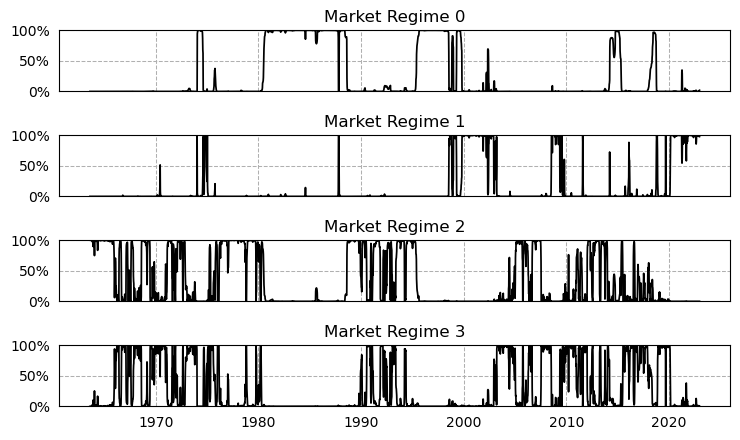

In [34]:
fig, axs = plt.subplots(nrows=emission_prob.shape[1], figsize=(width, height), sharex=True)
data = emission_prob.xs(emission_prob.index.get_level_values('as_of')[-1])
for i, ax in enumerate(axs):
    ax.plot(data[i], color='black', lw=1.25)
    ax.set_title(f'Market Regime {i}')
    ax.tick_params(axis='both', bottom=False, left=False)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
    ax.set_yticks([0, .5, 1])
    ax.grid(ls='--', lw=.75)
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig(f"{cfg.fldr}/img/emission_prob.pdf", dpi=dpi, transparent=True)
plt.show()

In [3]:
data.resample('Q').last()

,0,1,2,3
date,,,,
1963-09-30,0.000081,3.356964e-06,9.994929e-01,4.231119e-04
1963-12-31,0.000058,4.163449e-05,9.973030e-01,2.597015e-03
1964-03-31,0.000734,6.521421e-05,9.908377e-01,8.363044e-03
1964-06-30,0.000050,7.346896e-04,9.783184e-01,2.089641e-02
1964-09-30,0.000065,7.067021e-04,9.374692e-01,6.175866e-02
...,...,...,...,...
2021-12-31,1.000000,7.498415e-18,2.592076e-08,1.088780e-17
2022-03-31,0.999797,7.142908e-07,2.026135e-04,1.075347e-10
2022-06-30,0.999998,5.290756e-14,2.212256e-06,5.789850e-08


In [4]:
crsp = pd.read_pickle(f'{cfg.data_fldr}/crsp.pkl')
industry_mapping = crsp['industry'].copy()
mktcap = crsp['mktcap'].copy()
rt = pd.pivot_table(crsp[['excess_ret']], index='date', columns='permno', values='excess_ret')

In [5]:
industry_mapping.unique()

array(['Manufacturing', 'Utilities', 'Transportation', 'Retail',
       'Finance', 'Agriculture', 'Wholesale', 'Mining', 'Services',
       'Construction', 'Public', 'Missing'], dtype=object)

In [ ]:
mkt_indu = crsp[['industry', 'mktcap']].groupby(['date', 'industry']).sum()
df = crsp[['industry', 'mktcap']].join(mkt_indu.squeeze().rename('indu_size'), on=['date', 'industry']).join(crsp['excess_ret'])
df['wt'] = df['mktcap'].div(df['indu_size']).groupby('permno').shift(1)
df['wt_rt'] = df['wt'].mul(df['excess_ret'])
df

industry        mktcap     indu_size  excess_ret  \
date       permno                                                           
1960-01-31 10006.0  Manufacturing  6.912750e+04  1.933311e+08         NaN   
           10014.0  Manufacturing  1.118788e+04  1.933311e+08         NaN   
           10022.0  Manufacturing  2.017312e+04  1.933311e+08         NaN   
           10030.0  Manufacturing  7.998200e+04  1.933311e+08         NaN   
           10057.0  Manufacturing  2.650000e+04  1.933311e+08         NaN   
...                           ...           ...           ...         ...   
2022-12-31 93423.0       Services  1.933400e+06  8.068108e+09   -0.038169   
           93426.0  Manufacturing  4.850962e+05  1.414158e+10   -0.050626   
           93429.0        Finance  1.331011e+07  5.792405e+09   -0.014101   
           93434.0         Public  6.350827e+04  2.405469e+09    0.339042   
           93436.0         Public  3.889719e+08  2.405469e+09   -0.370634   

                          wt     wt_rt  
date       permno                       
1960-01-31 10006.0       NaN       NaN  
           10014.0       NaN       NaN  
           10022.0       NaN       NaN  
           10030.0       NaN       NaN  
           10057.0       NaN       NaN  
...                      ...       ...  
2022-12-31 93423.0  0.000231 -0.000009  
           93426.0  0.000034 -0.000002  
           93429.0  0.002194 -0.000031  
           93434.0  0.000017  0.000006  
           93436.0  0.220509 -0.081728  

[3431272 rows x 6 columns]

In [41]:
df['mktcap'].div(df['indu_size']).groupby('permno').shift(1)

date        permno 
1960-01-31  10006.0         NaN
            10014.0         NaN
            10022.0         NaN
            10030.0         NaN
            10057.0         NaN
                         ...   
2022-12-31  93423.0    0.000231
            93426.0    0.000034
            93429.0    0.002194
            93434.0    0.000017
            93436.0    0.220509
Length: 3431272, dtype: float64

In [36]:
w.to_frame('wt').join(crsp[['excess_ret', 'industry']])

wt  excess_ret       industry
date       permno                                      
1960-01-31 10006.0  0.000358         NaN  Manufacturing
           10014.0  0.000058         NaN  Manufacturing
           10022.0  0.000104         NaN  Manufacturing
           10030.0  0.000414         NaN  Manufacturing
           10057.0  0.000137         NaN  Manufacturing
...                      ...         ...            ...
2022-12-31 93423.0  0.000240   -0.038169       Services
           93426.0  0.000034   -0.050626  Manufacturing
           93429.0  0.002298   -0.014101        Finance
           93434.0  0.000026    0.339042         Public
           93436.0  0.161703   -0.370634         Public

[3431272 rows x 3 columns]

In [31]:
rt

permno,10000.0,10001.0,10002.0,10003.0,10005.0,10006.0,10007.0,10008.0,10009.0,10010.0,...,93423.0,93426.0,93428.0,93429.0,93430.0,93432.0,93433.0,93434.0,93435.0,93436.0
date,,,,,,,,,,,,,,,,,,,,,
1963-07-31,NaN,NaN,NaN,NaN,NaN,-0.047861,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-08-31,NaN,NaN,NaN,NaN,NaN,0.118581,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-09-30,NaN,NaN,NaN,NaN,NaN,-0.080370,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-10-31,NaN,NaN,NaN,NaN,NaN,0.054995,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-11-30,NaN,NaN,NaN,NaN,NaN,0.244066,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.024838,0.098485,NaN,-0.041858,NaN,NaN,NaN,0.345468,NaN,-0.074389
2022-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.202803,-0.139469,NaN,-0.006986,NaN,NaN,NaN,-0.431587,NaN,-0.039489
2022-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.257587,0.138288,NaN,0.058448,NaN,NaN,NaN,0.353864,NaN,-0.144468


In [28]:
df

industry        mktcap     indu_size
date       permno                                            
1960-01-31 10006.0  Manufacturing  6.912750e+04  1.933311e+08
           10014.0  Manufacturing  1.118788e+04  1.933311e+08
           10022.0  Manufacturing  2.017312e+04  1.933311e+08
           10030.0  Manufacturing  7.998200e+04  1.933311e+08
           10057.0  Manufacturing  2.650000e+04  1.933311e+08
...                           ...           ...           ...
2022-12-31 93423.0       Services  1.933400e+06  8.068108e+09
           93426.0  Manufacturing  4.850962e+05  1.414158e+10
           93429.0        Finance  1.331011e+07  5.792405e+09
           93434.0         Public  6.350827e+04  2.405469e+09
           93436.0         Public  3.889719e+08  2.405469e+09

[3431272 rows x 3 columns]

In [17]:
idx = industry_mapping[industry_mapping==indu].sort_index()
rtidx

date        permno 
1962-07-31  35932.0    Public
1962-08-31  35932.0    Public
1962-09-30  35932.0    Public
1962-10-31  35932.0    Public
1962-11-30  35932.0    Public
                        ...  
2022-12-31  93345.0    Public
            93356.0    Public
            93397.0    Public
            93434.0    Public
            93436.0    Public
Name: industry, Length: 102219, dtype: object

In [6]:
rt

permno,10000.0,10001.0,10002.0,10003.0,10005.0,10006.0,10007.0,10008.0,10009.0,10010.0,...,93423.0,93426.0,93428.0,93429.0,93430.0,93432.0,93433.0,93434.0,93435.0,93436.0
date,,,,,,,,,,,,,,,,,,,,,
1963-07-31,NaN,NaN,NaN,NaN,NaN,-0.047861,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-08-31,NaN,NaN,NaN,NaN,NaN,0.118581,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-09-30,NaN,NaN,NaN,NaN,NaN,-0.080370,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-10-31,NaN,NaN,NaN,NaN,NaN,0.054995,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-11-30,NaN,NaN,NaN,NaN,NaN,0.244066,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.024838,0.098485,NaN,-0.041858,NaN,NaN,NaN,0.345468,NaN,-0.074389
2022-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.202803,-0.139469,NaN,-0.006986,NaN,NaN,NaN,-0.431587,NaN,-0.039489
2022-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.257587,0.138288,NaN,0.058448,NaN,NaN,NaN,0.353864,NaN,-0.144468
